In [ ]:
# Jostautas Sakas 2110617 classes=["Background", "Car", "Cat", "Horse"]

In [ ]:
!pip install tensorflow==2.16.1
!pip install fiftyone

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers, models
import numpy as np
from google.colab import drive
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import fiftyone.zoo as foz
from PIL import Image

In [ ]:
drive.mount('/content/drive')
classes = ["Background", "Car", "Cat", "Horse"]
num_classes = 4
img_shape = 256
batch_size = 20 #20

In [ ]:
train_ds = foz.load_zoo_dataset(
    "open-images-v6",
    split="train",
    label_types=["segmentations"],
    classes=classes,
    max_samples=1000, #1000
)

test_ds = foz.load_zoo_dataset(
    "open-images-v6",
    split="validation",
    label_types=["segmentations"],
    classes=classes,
    max_samples=200, #200
)

In [23]:
def load_image_and_mask(image_path, mask_array, target_size=(img_shape, img_shape)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = image / 255.0

    mask = tf.image.resize(mask_array, target_size, method='nearest')

    return image, mask

def check_mask_labels(mask_array):
    unique_labels = np.unique(mask_array)
    print("Unique mask labels:", unique_labels)

def visualize_masks(original_mask, one_hot_mask, class_idx):
    num_classes = one_hot_mask.shape[-1]
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original_mask, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    for i in range(num_classes):
        plt.subplot(1, num_classes + 1, i+2)
        plt.imshow(one_hot_mask[:, :, i], cmap='gray')
        plt.title(f'Class {i} Mask')
        plt.axis('off')

    plt.show()

def get_class_index_from_label(label):
    class_map = {'Background': 0, 'Car': 1, 'Wheel': 1, 'Truck': 1, 'Cat': 2, 'Horse': 3, 'Mule': 3}
    return class_map.get(label, 0)  # Returns 0 if the label is not found

def preprocess_sample(sample, num_classes=num_classes):
    image_path = sample.filepath
    detection = sample['ground_truth'].detections[0]
    mask_array = detection.mask

    class_label = detection['label']
    print(class_label)
    class_index = get_class_index_from_label(class_label)

    mask_class_specific = np.where(mask_array, class_index, 0)

    mask_np = np.array(mask_array)

    check_mask_labels(mask_class_specific)

    mask_one_hot = tf.one_hot(mask_class_specific, depth=num_classes)
    mask_one_hot = tf.cast(mask_one_hot, tf.float32)

    mask_categorical = np.argmax(mask_one_hot.numpy(), axis=-1)
    visualize_masks(mask_np, mask_one_hot.numpy(), class_idx=0)

    image, mask = load_image_and_mask(image_path, mask_one_hot)

    return image, mask

In [24]:
def preprocess_fiftyone_dataset(fiftyone_dataset, num_classes=num_classes):
    images = []
    masks = []

    for sample in fiftyone_dataset:
        image, mask = preprocess_sample(sample, num_classes=num_classes)
        images.append(image)
        masks.append(mask)

    images_tensor = tf.stack(images)
    masks_tensor = tf.stack(masks)

    tf_dataset = tf.data.Dataset.from_tensor_slices((images_tensor, masks_tensor))
    tf_dataset = tf_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return tf_dataset

In [ ]:
train_tf_ds = preprocess_fiftyone_dataset(fiftyone_dataset=train_ds)
test_tf_ds = preprocess_fiftyone_dataset(fiftyone_dataset=test_ds)

In [41]:
def show_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # Assuming mask contains one-hot encoded classes
    mask_display = np.argmax(mask, axis=-1)  # Convert one-hot to single integer labels
    plt.imshow(mask_display, cmap='jet')  # 'jet' will color different classes differently
    plt.title('Mask')
    plt.axis('off')
    plt.colorbar()
    plt.show()

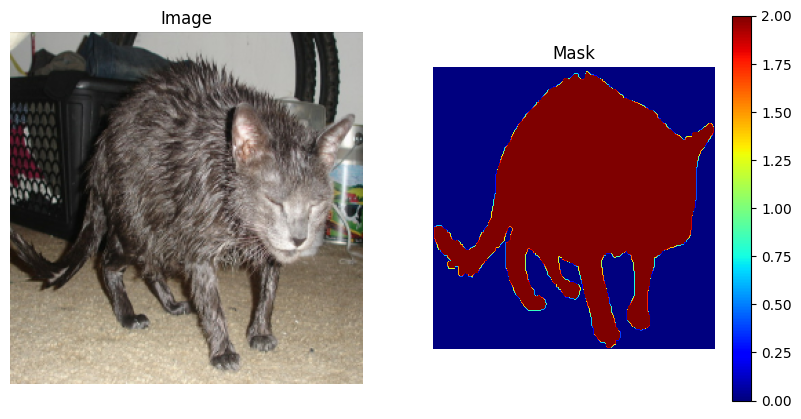

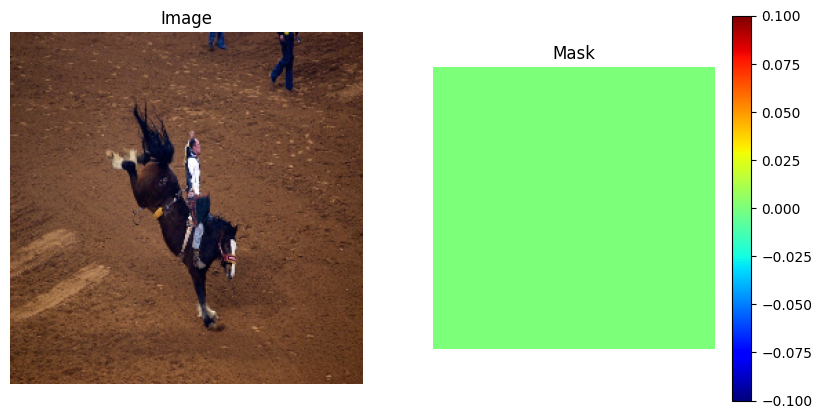

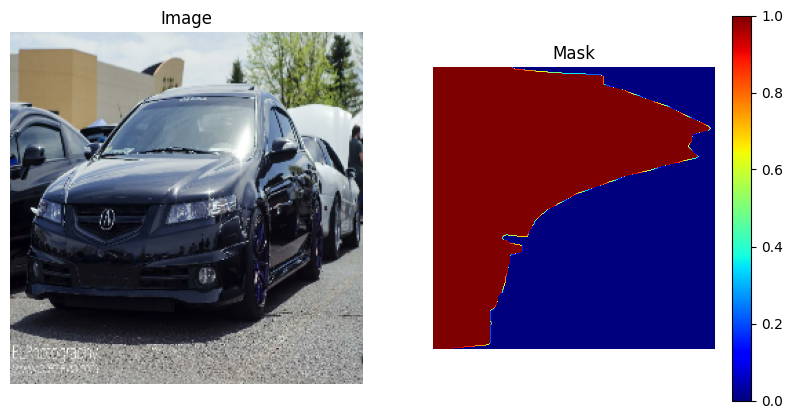

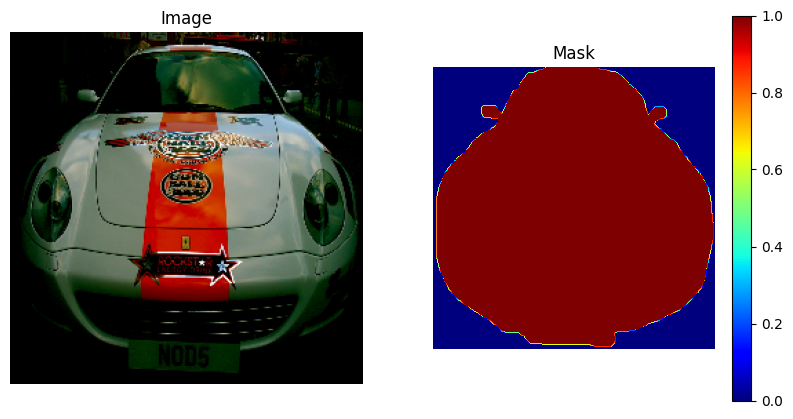

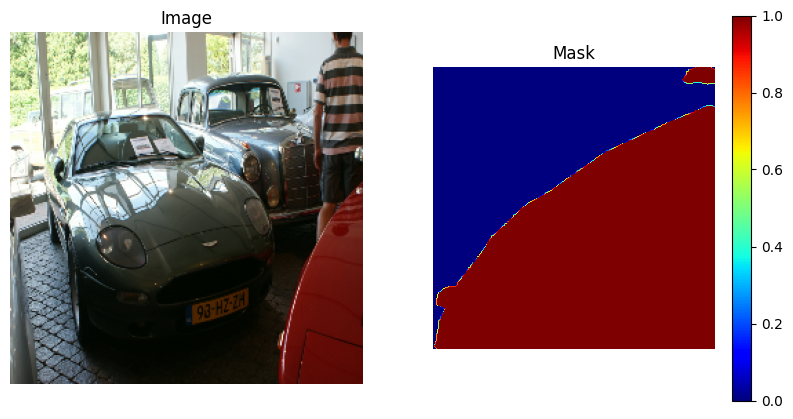

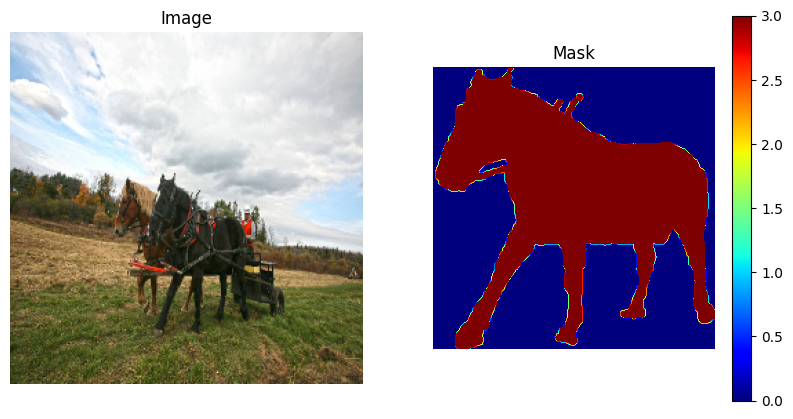

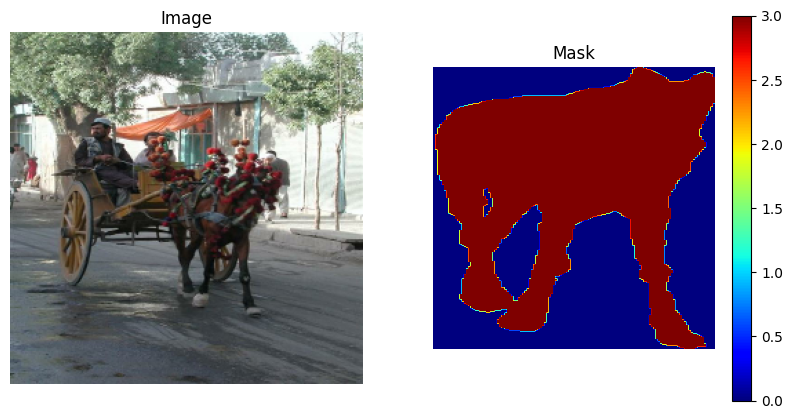

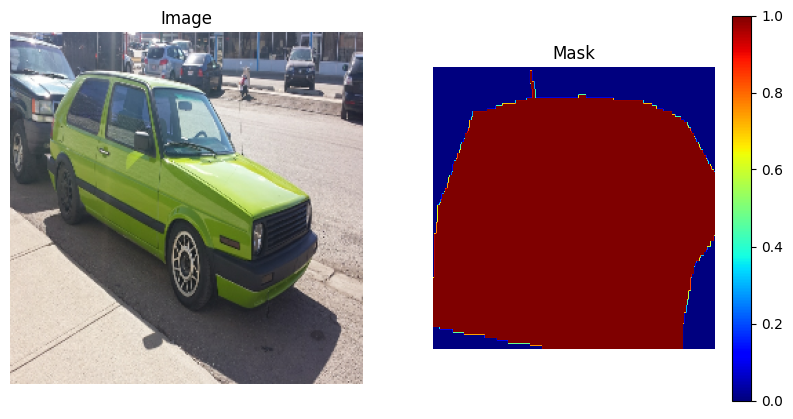

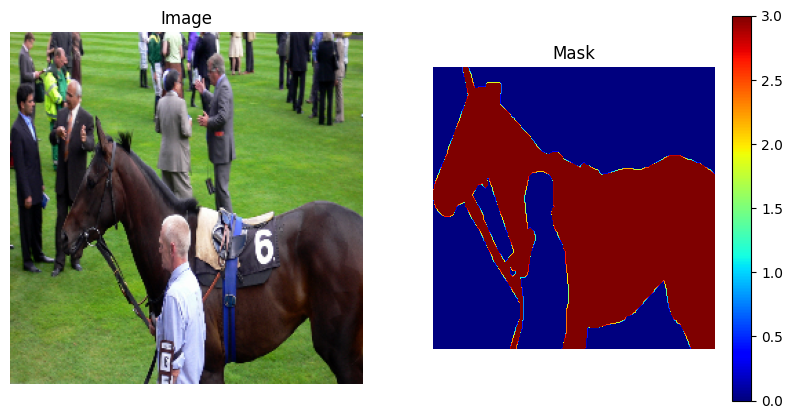

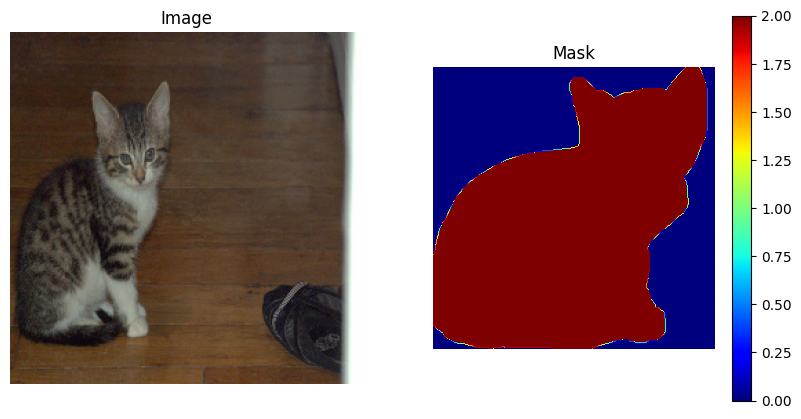

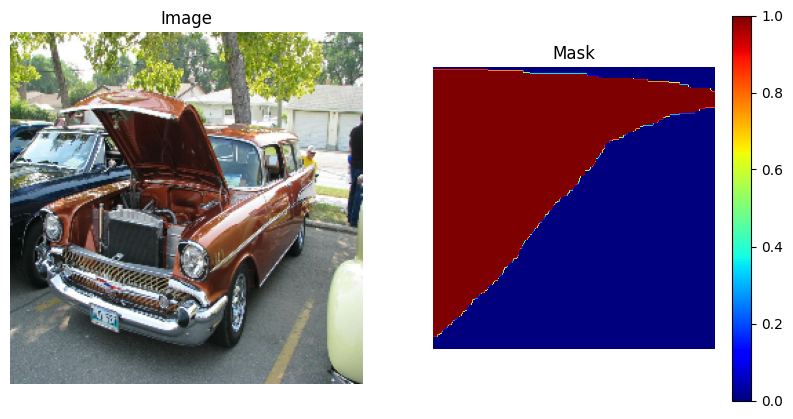

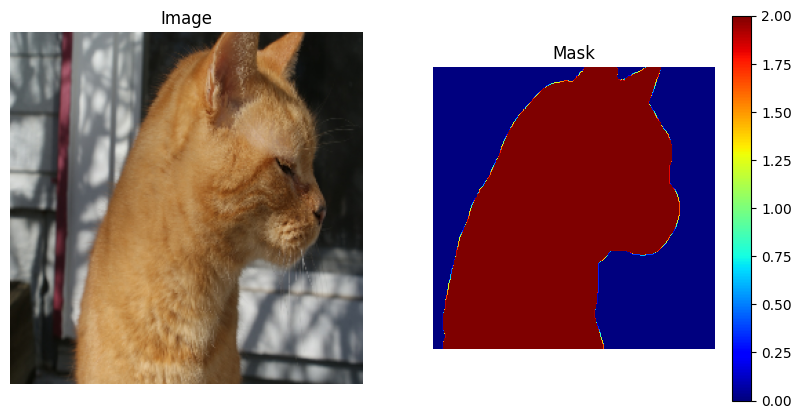

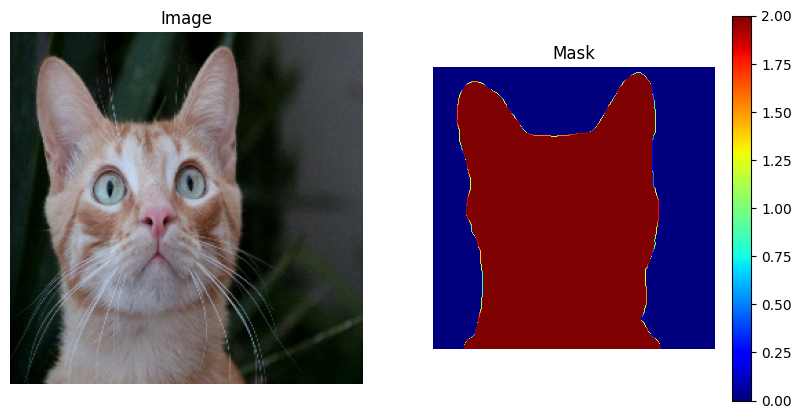

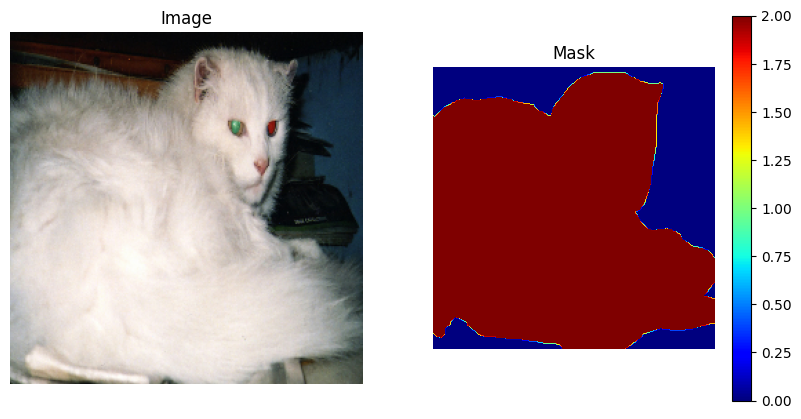

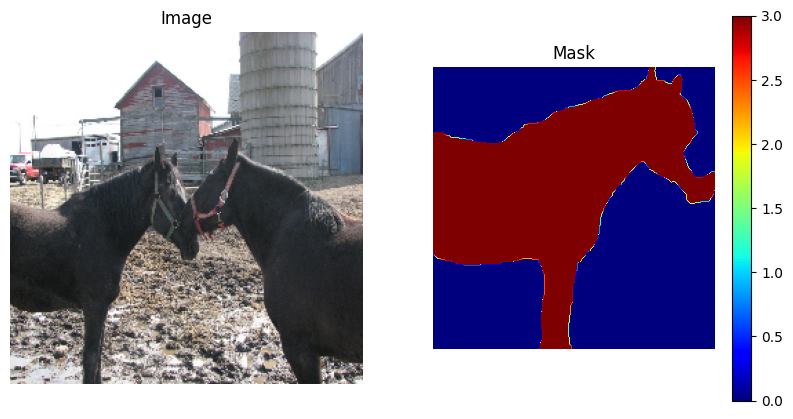

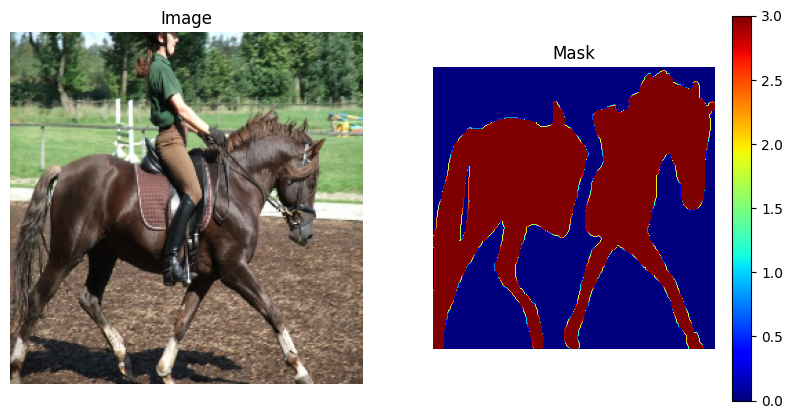

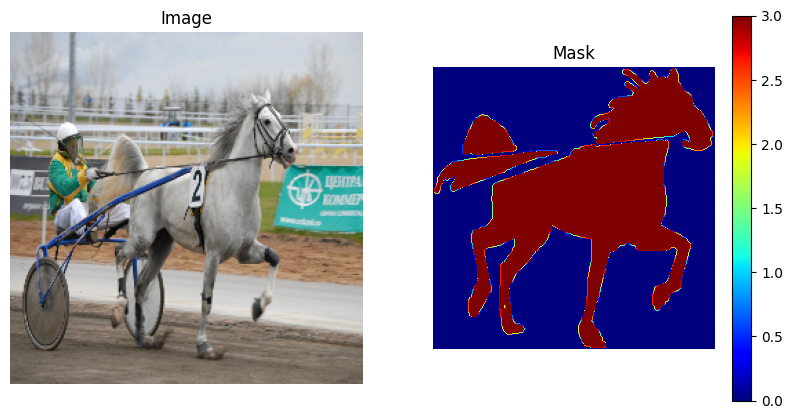

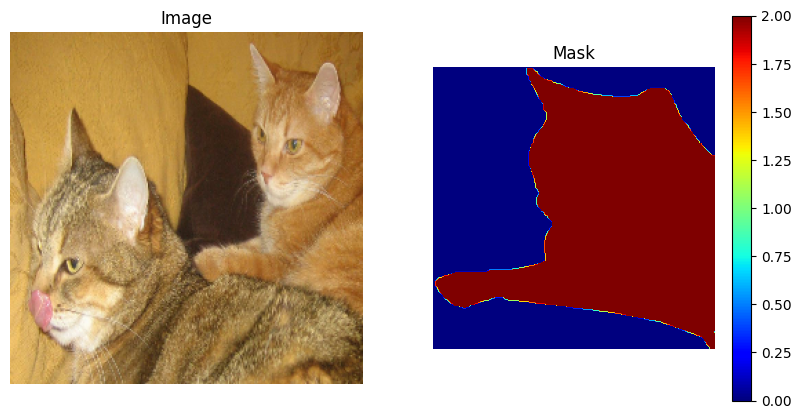

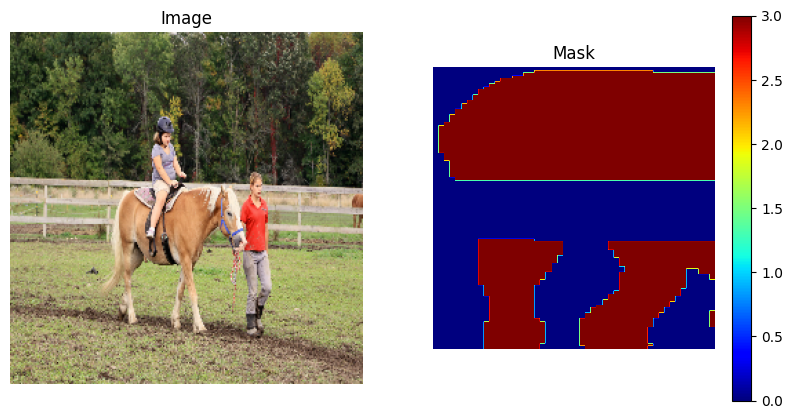

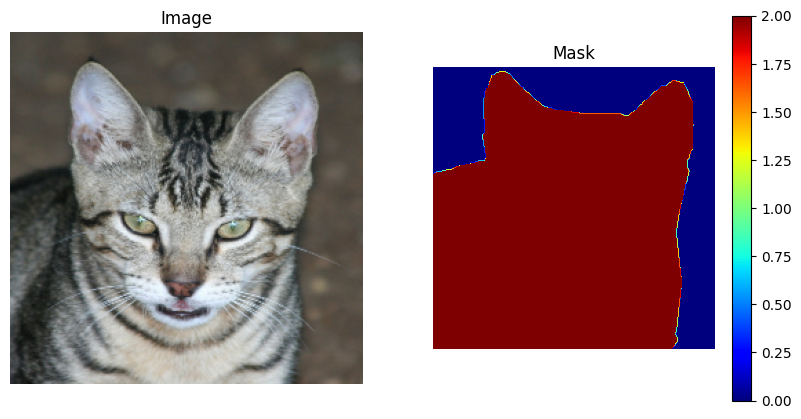

In [42]:
for image_batch, mask_batch in test_tf_ds.take(1):
    for i in range(image_batch.shape[0]):
        show_image_and_mask(image_batch.numpy()[i], mask_batch.numpy()[i])

In [28]:
def conv_block(inputs, filters):
    x = layers.Conv2D(filters, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.Conv2D(filters, (3, 3), activation="relu", padding="same")(x)
    x = Dropout(0.1)(x)
    return x

def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    x = layers.concatenate([x, skip_features], axis=-1)
    x = conv_block(x, filters)
    return x

def unet_model(input_shape=(img_shape, img_shape, 3), num_classes=num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    filters = 64
    c1, p1 = encoder_block(inputs, filters)
    c2, p2 = encoder_block(p1, filters * 2)
    c3, p3 = encoder_block(p2, filters * 4)
    c4, p4 = encoder_block(p3, filters * 8)

    b = conv_block(p4, filters * 16)

    d1 = decoder_block(b, c4, filters * 8)
    d2 = decoder_block(d1, c3, filters * 4)
    d3 = decoder_block(d2, c2, filters * 2)
    d4 = decoder_block(d3, c1, filters)

    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(d4)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model = unet_model(input_shape=(img_shape, img_shape, 3), num_classes=num_classes)

In [29]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1, num_classes])
    y_pred_f = tf.reshape(y_pred, [-1, num_classes])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)


def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00008),loss=dice_loss,metrics=[dice_coef])

In [31]:
epochs_number = 16
history = model.fit(train_tf_ds, epochs=epochs_number, validation_data=test_tf_ds)

Epoch 1/16
50/50 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - dice_coef: 0.2033 - loss: 0.7967 - val_dice_coef: 0.2418 - val_loss: 0.7582
Epoch 2/16
50/50 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - dice_coef: 0.2352 - loss: 0.7648 - val_dice_coef: 0.2439 - val_loss: 0.7561
Epoch 3/16
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - dice_coef: 0.2359 - loss: 0.7641 - val_dice_coef: 0.2447 - val_loss: 0.7553
Epoch 4/16
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - dice_coef: 0.2399 - loss: 0.7601 - val_dice_coef: 0.2502 - val_loss: 0.7498
Epoch 5/16
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - dice_coef: 0.2715 - loss: 0.7285 - val_dice_coef: 0.3146 - val_loss: 0.6854
Epoch 6/16
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - dice_coef: 0.3452 - loss: 0.6548 - val_dice_coef: 0.4024 - val_loss: 0.5976
Epoch 7/16
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - dice_coef: 0.3777 - loss: 0.6223 - val_dice_coef: 0.4325 - val_loss: 0.5675
Epoch 8/16
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - dice_coef: 0.3951 - loss: 0.6049 - val_dice_coef: 

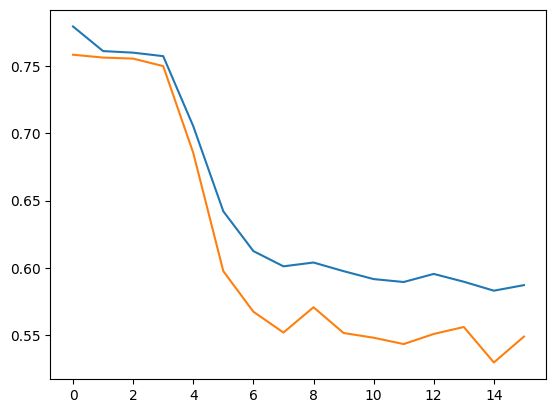

In [32]:
epochs = [i for i in range(epochs_number)]
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.show()

In [33]:
predictions = model.predict(test_tf_ds)
predicted_labels = np.argmax(predictions, axis=-1)

unique, counts = np.unique(predicted_labels, return_counts=True)
print(dict(zip(unique, counts)))

true_labels = []
for images, masks in test_tf_ds.unbatch():
    true_labels.append(np.argmax(masks.numpy(), axis=-1))
true_labels = np.concatenate(true_labels)

unique, counts = np.unique(true_labels, return_counts=True)
print(dict(zip(unique, counts)))

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step
{0: 5466376, 1: 2537664, 2: 4248996, 3: 854164}
{0: 6013544, 1: 2894434, 2: 2626138, 3: 1573084}


In [35]:
y_true = keras.backend.flatten(true_labels)
y_pred = keras.backend.flatten(predicted_labels)

f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print("F1 Score (Micro):", f1_micro)
print("F1 Score (Macro):", f1_macro)

F1 Score (Micro): 0.5365058898925781
F1 Score (Macro): 0.4584372084568947


In [ ]:
model.save('/content/drive/My Drive/model_5.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/model_2.h5', custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


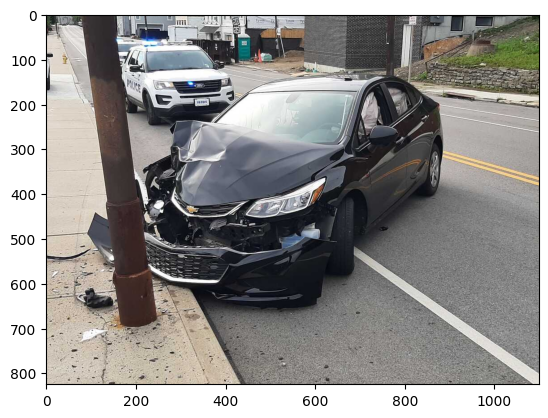

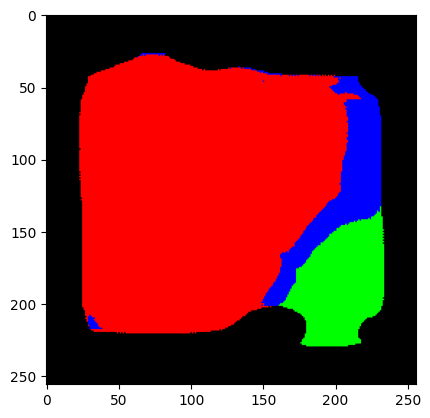

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


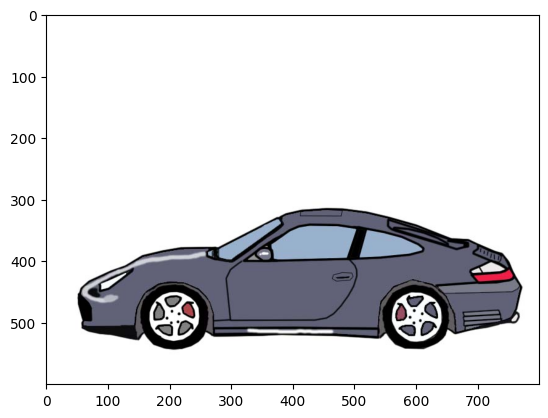

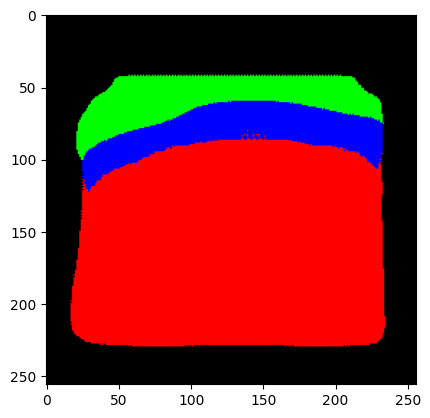

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


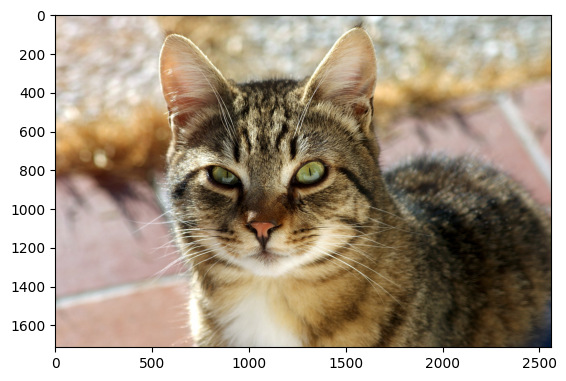

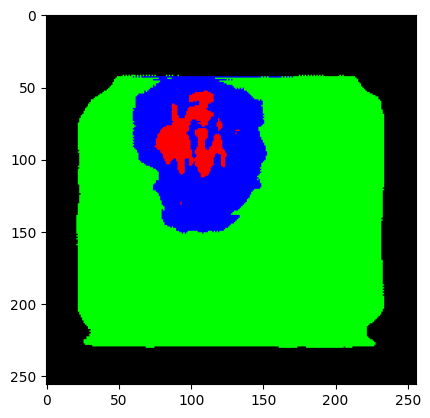

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


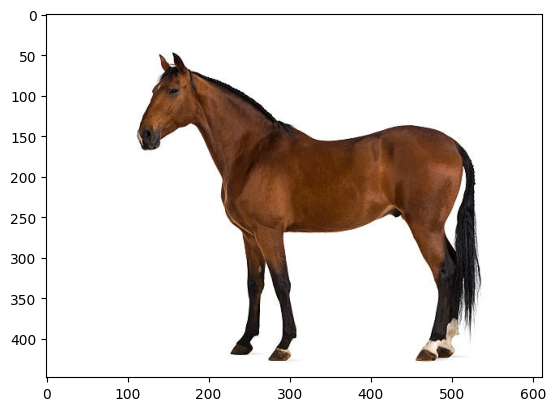

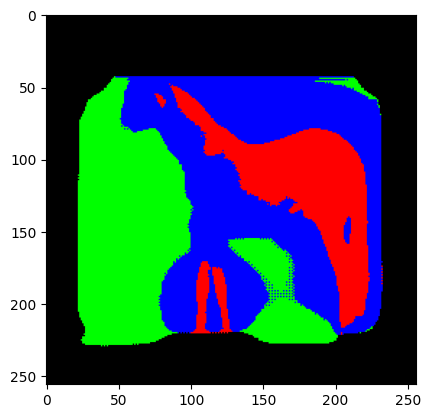

In [46]:
def convert_labels_to_color_image(labels, label_to_color):
    colored_mask = np.zeros((*labels.shape, 3), dtype=np.uint8)

    for label, color in label_to_color.items():
        colored_mask[labels == label] = color

    return Image.fromarray(colored_mask)


def preprocess_image(pil_img):
    img_array = np.array(pil_img) / 255.0
    img_array = tf.image.resize(img_array, [img_shape, img_shape])
    img_array = np.expand_dims(img_array, axis=0)
    return img_array.astype('float32')


def predict_sample(selected_image, model):
    img_array = preprocess_image(selected_image)
    prediction_mask = model.predict(img_array)
    predicted_labels = np.argmax(prediction_mask, axis=-1)[0]  # Remove batch dimension
    return predicted_labels

label_to_color = {
    0: [0, 0, 0],
    1: [255, 0, 0],  # Red = Car
    2: [0, 255, 0],  # Green = Cat
    3: [0, 0, 255]   # Blue = Horse
}


plt.imshow(plt.imread('/content/drive/My Drive/car3.jpg'))
predicted_labels = predict_sample(plt.imread('/content/drive/My Drive/car3.jpg'), model)
plt.show()
color_image = convert_labels_to_color_image(predicted_labels, label_to_color)
plt.imshow(color_image)
plt.show()
plt.imshow(plt.imread('/content/drive/My Drive/car.jpg'))
predicted_labels = predict_sample(plt.imread('/content/drive/My Drive/car.jpg'), model)
plt.show()
color_image = convert_labels_to_color_image(predicted_labels, label_to_color)
plt.imshow(color_image)
plt.show()

plt.imshow(plt.imread('/content/drive/My Drive/cat.jpg'))
predicted_labels = predict_sample(plt.imread('/content/drive/My Drive/cat.jpg'), model)
plt.show()
color_image = convert_labels_to_color_image(predicted_labels, label_to_color)
plt.imshow(color_image)
plt.show()

plt.imshow(plt.imread('/content/drive/My Drive/horse.jpg'))
predicted_labels = predict_sample(plt.imread('/content/drive/My Drive/horse.jpg'), model)
plt.show()
color_image = convert_labels_to_color_image(predicted_labels, label_to_color)
plt.imshow(color_image)
plt.show()